# Atrial Fibrillation Detection

This project aims to detect periods of AF from preprocessed ECG data by detecting irregular R-R intervals in the ECG signals. Different Machine Learning Classifiers are used to build an ML model using the given data. The performance of these various classifiers are analysed to determine the best classifier for this data. This is an interactive notebook that displays the results of our work. The entire source code can be found at the [GitHub](https://github.com/rushvanth/AFDetection) repository. 

It is highly recommended to run this Notebook in [Colab](https://colab.research.google.com/) in a GPU backed runtime. This drastically reduces run times while training models. In some cases, training time can be reduced from >5 hours (CPU processing - i7 1135G7) to ~4 minutes(GPU processing - NVIDIA T4). 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rushvanth/AFDetection/)


### RAPIDS Setup on Colab

Borrowed from [Rapids.ai](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&offline=true&sandboxMode=true)

#### Environment Sanity Check

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

#### Setup:
Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
     1. cuDF
     2. cuML
     3. cuGraph
     4. cuSpatial
     5. cuSignal
     6. BlazingSQL
     7. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.

In [ ]:
# This will get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel. Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab. This will restart your kernel one last time. Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# You can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

### Utility Functions

In [16]:
# Function to generate visualizations of classification results

import os
from sklearn import metrics
import  scikitplot as skplt
import matplotlib.pyplot as plt

def svm_feature_importance(coef, names, fig_path, plot_title):
    """Visualize the feature importance of the SVM classifier."""
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    # Plot the feature importance
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title(f'{plot_title} Feature Importance')
    plt.savefig(os.path.join(fig_path, 'feature_importance.png'))


def visualize_results(results, classifier_name):
    """Visualize ROC Curve, Confusion Matrix, Classification Report and Feature Importance."""
    feature_names = results['x_train'].columns.tolist()
    # Derive plot titles from classifier name. Make first letter uppercase and replace underscores with spaces
    plot_title = classifier_name.title().replace('_', ' ')
    # Join classifier_name with images_path
    fig_path = os.path.join('images', classifier_name)
    # Create directory if it doesn't exist
    if not os.path.exists(fig_path):
        os.makedirs(fig_path)
    # Feature Importance
    # If Classifier name has svm, use a different method to visualize feature importance
    if 'linear_svm' == classifier_name:
        svm_feature_importance(results['model'].coef_[0], feature_names, fig_path, plot_title)
    elif 'decision_tree' in classifier_name:
        skplt.estimators.plot_feature_importances(results['model'], feature_names=results['x_train'].columns, figsize=(14,6))
        plt.title(f'{plot_title} Feature Importance')
        plt.savefig(os.path.join(fig_path, 'feature_importance.png'))
    # ROC Curve
    roc_curve = metrics.RocCurveDisplay.from_predictions(results['y_test'], results['y_pred'])
    roc_curve.plot()
    plt.title(f'{plot_title} ROC Curve')
    plt.savefig(os.path.join(fig_path, 'roc_curve.png'))
    # Confusion Matrix
    skplt.metrics.plot_confusion_matrix(results['y_test'], results['y_pred'])
    plt.title(f'{plot_title} Confusion Matrix')
    plt.savefig(os.path.join(fig_path, 'confusion_matrix.png'))
    # Plot Precision-Recall Curve
    precision, recall, _ = metrics.precision_recall_curve(results['y_test'], results['y_pred'])
    precision_recall_display = metrics.PrecisionRecallDisplay(precision, recall)
    precision_recall_display.plot()
    plt.title(f'{plot_title} Precision-Recall Curve')
    plt.savefig(os.path.join(fig_path, 'precision_recall_curve.png'))

In [17]:
# Function to generate reports for each model

def generate_report(clf, classifier_name):

    print(f"{classifier_name} Results\n" + "-" * 50 + "\n")
    print('Accuracy: {:.4F} \n'.format(metrics.accuracy_score(clf['y_test'], clf['y_pred']) * 100))
    print('Confusion Matrix: \n', metrics.confusion_matrix(clf['y_test'], clf['y_pred']))
    print('Area under curve: {:.4F} \n'.format(metrics.roc_auc_score(clf['y_test'], clf['y_pred'])))
    print(metrics.classification_report(clf['y_test'], clf['y_pred']))
    print("-" * 50 + "\n")

In [ ]:
# Function to generate learning curves

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cuml.svm import SVC
from cuml.ensemble import RandomForestClassifier
from cuml.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


def prepare_learning_curve_data(X, y, classifier_name, title, kernel=None):
    fig, axes = plt.subplots(3, 1, figsize=(5, 20))
    # title = r"Learning Curves (SVM, Linear Kerner, $\gamma=0.001$)"
    # SVC is more expensive so we do a lower number of CV iterations:
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    if 'svm' in classifier_name:
        if kernel:
            estimator = SVC(kernel=kernel, gamma=0.001)
        else:
            estimator = SVC(gamma=0.001)
    elif classifier_name == "random_forest":
        estimator = RandomForestClassifier(n_estimators=100)    
    elif classifier_name == "knn":
        estimator = KNeighborsClassifier(n_neighbors=10)
    learning_curve = plot_learning_curve(
        estimator, title, X, y, axes=axes, ylim=(0.7, 1.01), cv=cv
    )

    plt.savefig(f'images/learning_curves/{classifier_name}_learning_curve.png')
    return learning_curve

In [ ]:
# Validation Curve functions

from sklearn.model_selection import validation_curve

def random_forest_validation_curve(X, y):
    rf = RandomForestClassifier()
    param_range = np.arange(1,250,10)

    train_scores, test_scores = validation_curve(rf, 
                                                X, 
                                                y, 
                                                param_name="n_estimators", 
                                                param_range=param_range,
                                                cv=3
                                                )

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="black")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

    # Create plot
    plt.title("Validation Curve With Random Forest")
    plt.xlabel("Number Of Trees")
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")
    plt.savefig('images/validation_curves/rf_validation_curve.png')

def knn_validation_curve(X, y):
    param_range = np.arange(1,20,1)
    # Calculate accuracy on training and test set using the
    # gamma parameter with 5-fold cross validation
    train_score, test_score = validation_curve(KNeighborsClassifier(), X, y,
                                        param_name = "n_neighbors",
                                        param_range = param_range,
                                            cv = 5)
    
    # Calculating mean and standard deviation of training score
    mean_train_score = np.mean(train_score, axis = 1)
    std_train_score = np.std(train_score, axis = 1)
    
    # Calculating mean and standard deviation of testing score
    mean_test_score = np.mean(test_score, axis = 1)
    std_test_score = np.std(test_score, axis = 1)
    
    # Plot mean accuracy scores for training and testing scores
    plt.plot(param_range, mean_train_score,
        label = "Training Score", color = 'b')
    plt.plot(param_range, mean_test_score,
    label = "Cross Validation Score", color = 'g')
    
    # Creating the plot
    plt.title("Validation Curve with KNN Classifier")
    plt.xlabel("Number of Neighbours")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend(loc = 'best')
    plt.savefig('images/validation_curves/knn_validation_curve.png')

def svm_validation_curve(X, y, kernel=None):
    param_range = np.logspace(-6, -1, 5)
    if kernel:
        svm = SVC(kernel=kernel)
    else:
        svm = SVC()
    train_scores, test_scores = validation_curve(
        svm,
        X,
        y,
        param_name="gamma",
        param_range=param_range,
        scoring="accuracy"
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel(r"$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(
        param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.semilogx(
        param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
    )
    plt.fill_between(
        param_range,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.savefig('images/validation_curves/svm_validation_curve.png')

### Generate Metadata for Dataset

Metadata:
--------------------------------------------------

Classes: [0 1] 

Class Labels: 
 0 - Non AF
 1 - AF

Data in the 'Control' column: {0: 113463, 1: 36537} 

Ratio of occurrences of each class: {0: 0.75642, 1: 0.24358}

--------------------------------------------------



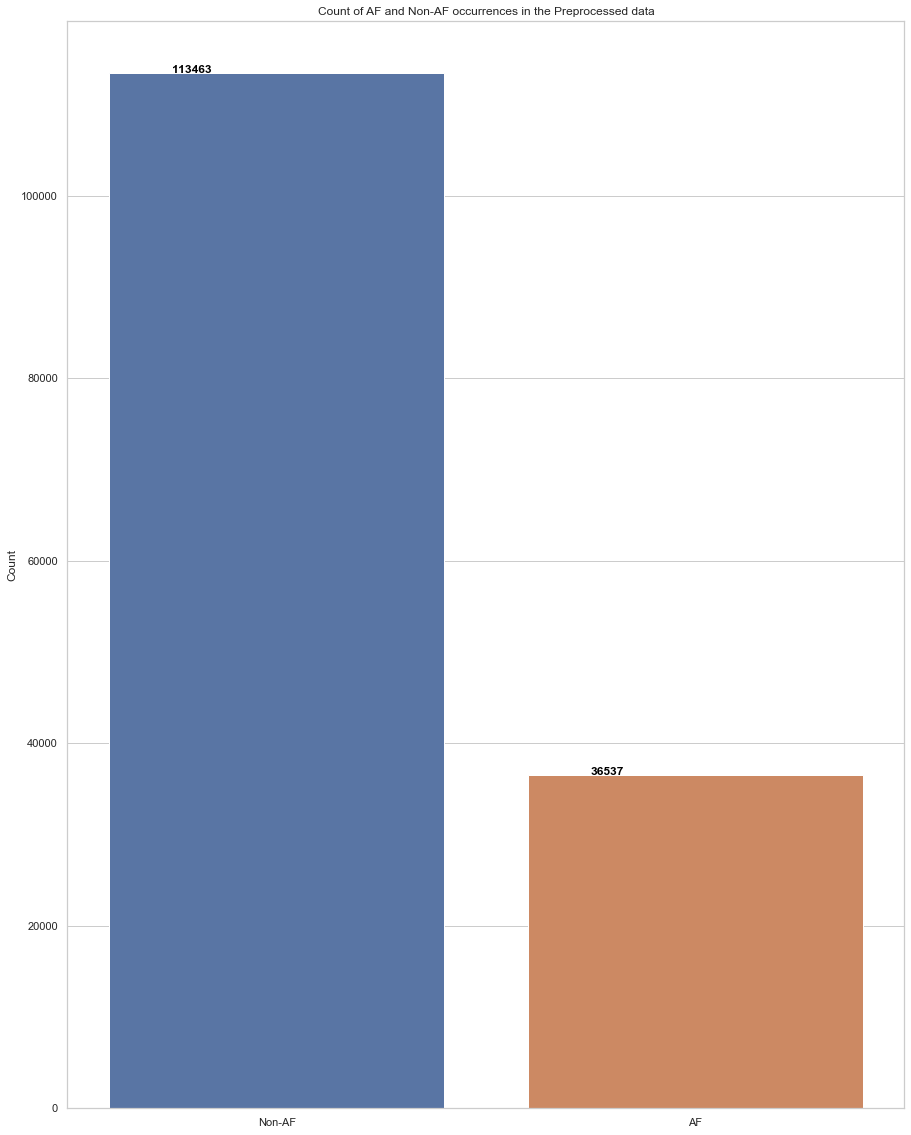

In [18]:
"""Load Data and generate some metadata regarding the classes"""
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the file from the data directory
af_data = pd.read_csv('data/Preprocessed_AFData.csv')
# Print some metadata about the classes
(unique,counts) = np.unique(af_data['Control'],return_counts=True)
print("Metadata:\n" + "-"*50 + "\n")
print(f"Classes: {str(unique)} \n")
print("Class Labels: \n 0 - Non AF\n 1 - AF\n")
print(f"Data in the 'Control' column: {dict(zip(unique,counts))} \n")
print(f"Ratio of occurrences of each class: {dict(zip(unique,counts/len(af_data['Control'])))}\n")
print("-"*50 + "\n")
# Display counts on a graph and save it
target_variables = ['Non-AF','AF']
sns.set_theme(style='whitegrid')
sns.barplot(x=target_variables,y=counts)
plt.title('Count of AF and Non-AF occurrences in the Preprocessed data')
plt.ylabel('Count')
for i,_ in enumerate(counts):
    plt.text(i-0.25, counts[i]+0.5, counts[i], color='black', fontweight='bold')
img_file_path = 'images/general/count_of_AF_and_Non_AF_occurrences.png'
plt.savefig(img_file_path)

### Visualize Correlation Between Features

Text(0.5, 1.0, 'Correlation Matrix of the Preprocessed data')

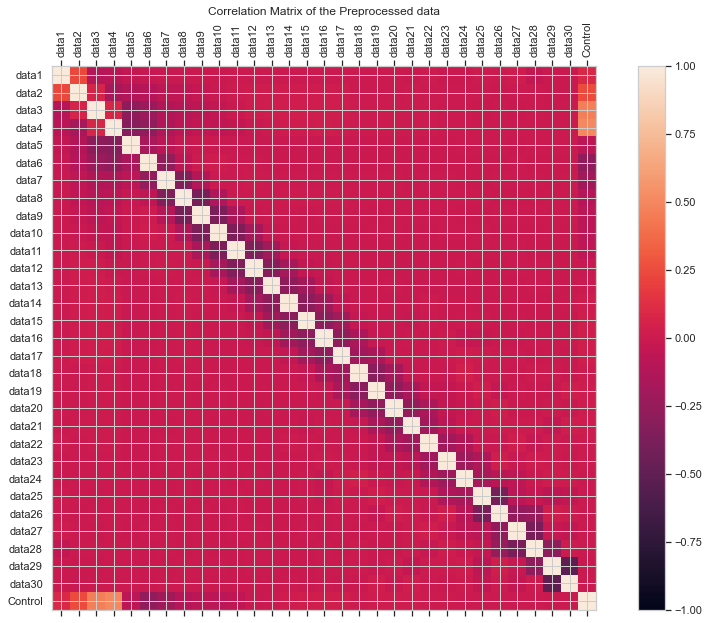

In [8]:
# Plot heatmap of the correlation matrix
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(af_data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0,len(af_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(af_data.columns)
ax.set_yticklabels(af_data.columns)
plt.title('Correlation Matrix of the Preprocessed data')

### Visualize Density Plots

In [ ]:
# Plot features densities depending on the outcome values
from pylab import rcParams
rcParams['figure.figsize'] = 15, 20

# separate data based on outcome values 
outcome_0 = af_data[af_data['Control'] == 0]
outcome_1 = af_data[af_data['Control'] == 1]
names = list(af_data.columns)
# plot densities for outcomes
i=0
j=0
for _ in range(3):
    # init figure
    fig, axs = plt.subplots(10, 1)
    fig.suptitle('Features densities for different outcomes 0/1')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.9)
    for column_name in names[i:i+10]: 
        ax = axs[j]
        #plt.subplot(4, 2, names.index(column_name) + 1)
        outcome_0[column_name].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color="red", legend=True,
                                    label=column_name + ' for Outcome = 0')
        outcome_1[column_name].plot(kind='density', ax=ax, subplots=True, 
                                        sharex=False, color="green", legend=True,
                                        label=column_name + ' for Outcome = 1')
        ax.grid('on')
        j+=1
    i+=10
    j=0
    plt.show()

### Split the data to obtain Train and Test Sets

In [19]:
from sklearn.model_selection import train_test_split

X = af_data.drop(['Control'],axis=1)
y = af_data['Control']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

### Plot Learning Curves

In [ ]:
# Linear SVM
plot = prepare_learning_curve_data(X, y, 'linear_svm', r'Learning Curve (SVM, Linear Kernel, $\gamma=0.001)', kernel='linear')
plot.show()

In [ ]:
# SVM with RBF kernel

plot = prepare_learning_curve_data(X, y, classifier_name='rbf_svm', title= r'Learning Curve (SVM, RBF Kernel, $\gamma=0.001)')
plot.show()

In [ ]:
# Random Forest Model
# Convert data to float32 as cuML's RF implementation only accepts float32 data
X = X.astype(np.float32)
y = y.astype(np.float32)
plot = prepare_learning_curve_data(X, y, classifier_name='random_forest', title=r'Learning Curve (Random Forest)')
plot.show()

In [ ]:
# KNN Classifier learning curves
plot = prepare_learning_curve_data(X, y, classifier_name='knn', title=r'Learning Curve (10-Nearest Neighbours)')
plot.show()

### Plot Validation Curves

In [ ]:
# Linear SVM Validation Curve
validation_plot = svm_validation_curve(X, y, kernel='linear')

In [ ]:
# SVM with RBF kernel Validation Curve
validation_plot = svm_validation_curve(X, y, kernel='rbf')

In [ ]:
# Random Forest Validation Curve
validation_plot = random_forest_validation_curve(X, y)

In [ ]:
# KNN Validation Curve
validation_plot = knn_validation_curve(X, y)

### Use ML Classifiers to predict AF outcome

In [ ]:
# Linear SVM
kernel = 'linear'
print(f"Training Support Vector Machine with {kernel} kernel...\n")
svm = SVC(kernel=kernel, random_state=101)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
clf = {'model': svm, 'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'y_pred': y_pred}
generate_report(clf, 'linear_svm')
visualize_results(clf, 'linear_svm')

In [ ]:
# SVM with RBF kernel
kernel = 'rbf'
print(f"Training Support Vector Machine with {kernel} kernel...\n")
svm = SVC(kernel=kernel, random_state=101)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
clf = {'model': svm, 'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'y_pred': y_pred}
generate_report(clf, 'linear_svm')
visualize_results(clf, 'rbf_svm')

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

print(f"Training Decision Tree...\n")
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=101)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
clf = {'model': dt, 'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'y_pred': y_pred}
generate_report(clf, 'decision_tree')
visualize_results(clf, 'decision_tree')

In [ ]:
# Random Forest
print(f"Training Random Forest...\n")
X = X.astype(np.float32)
y = y.astype(np.float32)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
rf = RandomForestClassifier(n_estimators=100, random_state=101)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
clf = {'model': rf, 'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'y_pred': y_pred}
generate_report(clf, 'random_forest')
visualize_results(clf, 'random_forest')

### Dealing with Class Imbalance

1. Weighted ML models
2. SMOTE

In [21]:
# Comparing Weighted Logistic Regression and Logistic Regression
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=101, class_weight=None, max_iter=1000)
lg.fit(x_train, y_train)
y_pred = lg.predict(x_test)
clf = {'model': lg, 'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'y_pred': y_pred}
generate_report(clf, 'logistic_regression')

logistic_regression Results
--------------------------------------------------

Accuracy: 93.3033 

Confusion Matrix: 
 [[22183   568]
 [ 1441  5808]]
Area under curve: 0.8881 

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     22751
           1       0.91      0.80      0.85      7249

    accuracy                           0.93     30000
   macro avg       0.92      0.89      0.90     30000
weighted avg       0.93      0.93      0.93     30000

--------------------------------------------------



In [22]:
# Defind class weight for Logistic Regression
class_weight = {0: 25, 1: 75}
weighted_lg = LogisticRegression(random_state=101, class_weight=class_weight, max_iter=1000)
weighted_lg.fit(x_train, y_train)
y_pred = weighted_lg.predict(x_test)
clf = {'model': weighted_lg, 'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test, 'y_pred': y_pred}
generate_report(clf, 'weighted_logistic_regression')

weighted_logistic_regression Results
--------------------------------------------------

Accuracy: 94.4167 

Confusion Matrix: 
 [[21841   910]
 [  765  6484]]
Area under curve: 0.9272 

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     22751
           1       0.88      0.89      0.89      7249

    accuracy                           0.94     30000
   macro avg       0.92      0.93      0.92     30000
weighted avg       0.94      0.94      0.94     30000

--------------------------------------------------



In [ ]:
# Perform a Grid search to find the best weights for the Logistic Regression
from sklearn.model_selection import GridSearchCV
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {'class_weight': w}
weighted_lg_with_gridsearch = LogisticRegression(random_state=101, max_iter=1000)
grid_search = GridSearchCV(estimator=weighted_lg_with_gridsearch, param_grid=hyperparam_grid, cv=100, scoring='roc_auc', refit=True)
grid_search.fit(x_train, y_train)
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_parameters}")
print(f"Best score: {best_score}")